In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# from nltk.tokenize import word_tokenize as wt 
# from collections import Counter
# import gensim
# import textblob
import spacy

## **Plan of Action**

- Load the data
- Drop unnecessary columns and rows
- Removal of stop words.
- Feature engineering;
    - TF-IDF
- Begin modelling
    - Algorithms to use;
        - k-Nearest Neighbors.
        - Decision Trees.
        - Naive Bayes.
        - Random Forest.
        - Gradient Boosting.
        - Logistic Regression
- Evaluation;
    - F1-score_macro
    - AUC
    - ROC

In [2]:
df_clean = pd.read_csv('../../cleaned_reviews.csv')

In [3]:
df_clean.shape

(17340, 4)

In [4]:
df_clean.columns

Index(['sentiments', 'cleaned_review', 'cleaned_review_length',
       'review_score'],
      dtype='object')

In [5]:
df_clean.drop(columns=['cleaned_review_length','review_score'],inplace=True)

Checking for Null Vaules and Duplicates

In [6]:
df_clean.isna().sum()

sentiments        0
cleaned_review    3
dtype: int64

In [7]:
df_clean.dropna(inplace=True)

In [8]:
df_clean.shape

(17337, 2)

In [9]:
from spacy.lang.en.stop_words import STOP_WORDS

# print(STOP_WORDS,'\n') # <- set of Spacy's default stop words
all_stopwords = STOP_WORDS
# Adding several stopwords
# all_stopwords |= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against'}

# Removing several stop words
all_stopwords-= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against','off','against','too'}
my_stop_words = set(all_stopwords) # My own stop words

In [10]:
df_clean

,sentiments,cleaned_review
0,positive,i wish would have gotten one earlier love it a...
1,neutral,i ve learned this lesson again open the packag...
2,neutral,it is so slow and lags find better option
3,neutral,roller ball stopped working within months of m...
4,neutral,i like the color and size but it few days out ...
...,...,...
17335,positive,i love this speaker and love can take it anywh...
17336,positive,i use it in my house easy to connect and loud ...
17337,positive,the bass is good and the battery is amazing mu...
17338,positive,love it


In [11]:
nlp = spacy.load("en_core_web_sm")
df_clean['lemma_review'] = df_clean['cleaned_review'].apply(lambda text: 
                         " ".join(token.lemma_ for token in nlp(text) 
                            if token.text not in my_stop_words))
df_clean.head(5)

,sentiments,cleaned_review,lemma_review
0,positive,i wish would have gotten one earlier love it a...,wish get early love make work laptop easy
1,neutral,i ve learned this lesson again open the packag...,ve learn lesson open package use product right...
2,neutral,it is so slow and lags find better option,slow lag find well option
3,neutral,roller ball stopped working within months of m...,roller ball stop work month minimal use piece ...
4,neutral,i like the color and size but it few days out ...,like color size day return period not hold charge


In [12]:
# Dropping unnecessary columns
df_clean.drop(columns=['cleaned_review'],inplace=True)

Sentiment Mapping

In [13]:
sentiment_mapping = {'negative':-1,'neutral':0,'positive':1}
df_clean['sentiment_label'] = df_clean.sentiments.map(sentiment_mapping)

In [14]:
df_clean.drop(columns=['sentiments'],inplace=True)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit,cross_val_score

# The algorithms
from sklearn.ensemble import GradientBoostingClassifier,HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

Approaches;
- Use of Unigrams

## **Using df_clean**

### **Unigrams**

In [16]:
tfidf_vectorizer = TfidfVectorizer()

In [17]:
X  = tfidf_vectorizer.fit_transform(df_clean.iloc[:,0]).toarray()
y = df_clean.iloc[:,-1]

In [18]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)

In [19]:
models = {
   
    "GB": GradientBoostingClassifier(max_depth=3),
    "LR": LogisticRegression(multi_class='multinomial',solver='lbfgs'),
    "HGB": HistGradientBoostingClassifier(max_depth=3)
}

In [20]:
# https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f
# The abov link explains why f1_macro was used
model_results_f1_macro = []
model_names = []
model_mean = []

In [21]:
my_cv = StratifiedShuffleSplit(n_splits=5,test_size=.1,random_state=42) # 10% for validation 
scoring = 'f1_macro'
for name, model in models.items():
    model_names.append(name) # append each name of the model
    print(model) # print the model name for checks
    cv_results = cross_val_score(model,X_train,y_train,scoring=scoring,cv=my_cv,n_jobs=-2) 
    cv_results_list = cv_results.tolist() # Turning the array to a list
    model_results_f1_macro.append(cv_results_list) # append validation results
    model_mean.append(cv_results.mean()) # append the mean

GradientBoostingClassifier()
LogisticRegression(multi_class='multinomial')
HistGradientBoostingClassifier(max_depth=3)


In [22]:
print(model_results_f1_macro)
print(model_names)
print(model_mean)

[[0.713785283865474, 0.7191897431904487, 0.7102721921829951, 0.7108580552216482, 0.6920138686295502], [0.707761108898428, 0.7668268760265767, 0.7226898392261581, 0.735620615556563, 0.7265899438351098], [0.7141975292623995, 0.7316234634793605, 0.7136578622649198, 0.7263001151910907, 0.7213731650313034]]
['GB', 'LR', 'HGB']
[0.7092238286180232, 0.7318976767085672, 0.7214304270458147]


In [23]:
# Creating a Dictionary of results
f1score_result_dict = dict(zip(model_names,model_results_f1_macro))
f1score_mean_dict = dict(zip(model_names,model_mean))

In [24]:
# Creating a Dataframe of results
f1score_result_frame = pd.DataFrame(f1score_result_dict)
f1score_mean_frame = pd.Series(f1score_mean_dict).to_frame('mean_f1_score').reset_index()
f1score_mean_frame.rename(columns={'index':'models'},inplace=True)

In [25]:
f1score_result_frame

,GB,LR,HGB
0,0.713785,0.707761,0.714198
1,0.719190,0.766827,0.731623
2,0.710272,0.722690,0.713658
3,0.710858,0.735621,0.726300
4,0.692014,0.726590,0.721373


In [30]:
f1score_result_frame.to_csv("validation_tfidf/unigram_f1score_tfidf_results.csv",index=False)

In [31]:
f1score_mean_frame.sort_values(by='mean_f1_score',ascending=False)

,models,mean_f1_score
1,LR,0.731898
2,HGB,0.721430
0,GB,0.709224


In [32]:
f1score_mean_frame.to_csv("validation_tfidf/unigram_f1score_tfidf_mean_results.csv",index=False)

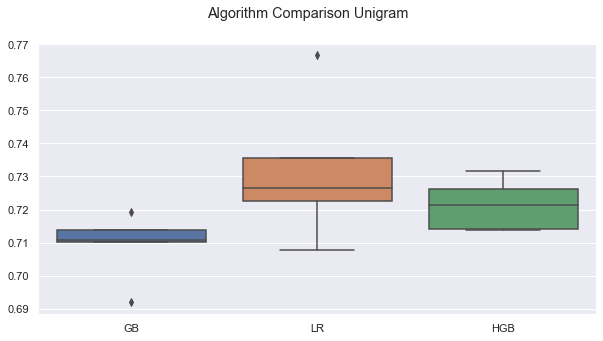

In [33]:
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=f1score_result_frame)
ax.set_xticklabels(model_names)
fig.suptitle('Algorithm Comparison Unigram')
plt.show()

The unigram approach is quite computationally expensive but Logistic regression has a better performance.

## **Model  Building**

### **df_clean**

Starting with df_clean
- Grid search shall be used to fine tune Logistic Regression
- PCA shall also be used with Logistic Regression to see if the perfomance on the training set.

In [34]:
tfidf_vectorizer = TfidfVectorizer()
X  = tfidf_vectorizer.fit_transform(df_clean.iloc[:,0]).toarray()
y = df_clean.iloc[:,-1]

Text(0.5, 1.0, 'Using PCA for Feature Engineering')

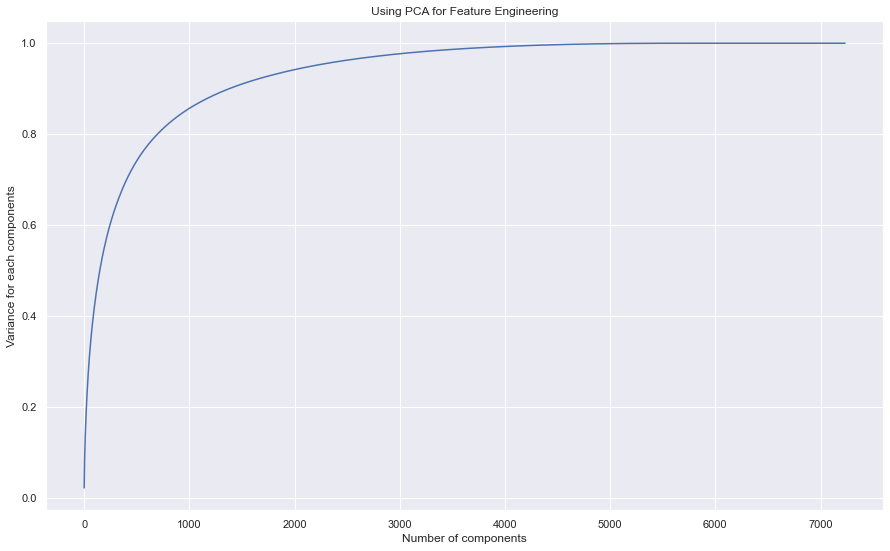

In [35]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)
pca_data = pca.transform(X)

# plotting the cumulative summation of the explained variance
sns.set_theme(style='darkgrid')
fig,ax = plt.subplots(figsize=(15,9))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance for each components')
ax.set_title("Using PCA for Feature Engineering")

In [36]:
exp_var_cumsum = pd.Series(np.round(pca.explained_variance_ratio_.cumsum(),4)*100)

for index,var in enumerate(exp_var_cumsum):
    print(f'If pca components is: {index}    Variance: {np.around(var,3)}')

# If pca components is: 1378    Variance: 90.0

If pca components is: 0    Variance: 2.15
If pca components is: 1    Variance: 4.03
If pca components is: 2    Variance: 5.79
If pca components is: 3    Variance: 7.16
If pca components is: 4    Variance: 8.25
If pca components is: 5    Variance: 9.26
If pca components is: 6    Variance: 10.17
If pca components is: 7    Variance: 10.99
If pca components is: 8    Variance: 11.78
If pca components is: 9    Variance: 12.55
If pca components is: 10    Variance: 13.31
If pca components is: 11    Variance: 14.03
If pca components is: 12    Variance: 14.73
If pca components is: 13    Variance: 15.39
If pca components is: 14    Variance: 16.03
If pca components is: 15    Variance: 16.61
If pca components is: 16    Variance: 17.18
If pca components is: 17    Variance: 17.74
If pca components is: 18    Variance: 18.29
If pca components is: 19    Variance: 18.83
If pca components is: 20    Variance: 19.34
If pca components is: 21    Variance: 19.85
If pca components is: 22    Variance: 20.36
If p

Two models for df_clean;
- model without pca
- model with pca 

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)

In [39]:
# Without PCA
pipe = Pipeline([('clf',LogisticRegression(multi_class='multinomial',solver='lbfgs'))])

In [40]:
paramter_grid = {'clf__C':[0.0001,0.001,0.1,1,10,100]
                }
my_cv = StratifiedShuffleSplit(n_splits=5,test_size=.1,random_state=42)

In [41]:
mygrid = GridSearchCV(pipe,param_grid=paramter_grid,cv=my_cv,scoring='f1_macro')
mygrid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.1,
            train_size=None),
             estimator=Pipeline(steps=[('clf',
                                        LogisticRegression(multi_class='multinomial'))]),
             param_grid={'clf__C': [0.0001, 0.001, 0.1, 1, 10, 100]},
             scoring='f1_macro')

In [42]:
print(f"Best params: {mygrid.best_params_}\n")
print(f"Best estimator: {mygrid.best_estimator_}\n")
print(f"Best validation score: {mygrid.best_score_}")

Best params: {'clf__C': 100}

Best estimator: Pipeline(steps=[('clf', LogisticRegression(C=100, multi_class='multinomial'))])

Best validation score: 0.8042101667210713


In [43]:
mygrid_trainset = mygrid.best_estimator_
mygrid_trainset

# Pipeline(steps=[('clf', LogisticRegression(C=100, multi_class='multinomial',solver="lbfgs"))])
# Best validation score: 0.8042101667210713

Pipeline(steps=[('clf', LogisticRegression(C=100, multi_class='multinomial'))])

              precision    recall  f1-score   support

          -1       0.96      0.93      0.95      1227
           0       0.95      0.95      0.95      5040
           1       0.97      0.98      0.97      7602

    accuracy                           0.96     13869
   macro avg       0.96      0.95      0.96     13869
weighted avg       0.96      0.96      0.96     13869



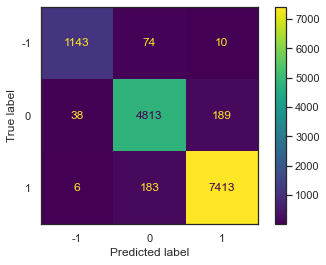

In [44]:
# Classification report
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_pred_train = mygrid_trainset.predict(X_train)



y_train = y_train
sns.set_theme(style='white')
def class_report(model,y_train,y_pred_train):
    print(classification_report(y_train,y_pred_train))
    cm = confusion_matrix(y_train,y_pred_train,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()


class_report(mygrid_trainset,y_train,y_pred_train)

In [45]:
# With PCA
pipe = Pipeline([('pca',PCA(.90)),
('clf',LogisticRegression(multi_class='multinomial',solver='lbfgs'))])

In [46]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)

In [47]:
paramter_grid = {'clf__C':[0.0001,0.001,0.1,1,10,100]
                }
my_cv = StratifiedShuffleSplit(n_splits=5,test_size=.1,random_state=42)

In [48]:
mygrid = GridSearchCV(pipe,param_grid=paramter_grid,cv=my_cv,scoring='f1_macro')
mygrid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.1,
            train_size=None),
             estimator=Pipeline(steps=[('pca', PCA(n_components=0.9)),
                                       ('clf',
                                        LogisticRegression(multi_class='multinomial'))]),
             param_grid={'clf__C': [0.0001, 0.001, 0.1, 1, 10, 100]},
             scoring='f1_macro')

In [49]:
print(f"Best params: {mygrid.best_params_}\n")
print(f"Best estimator: {mygrid.best_estimator_}\n")
print(f"Best validation score: {mygrid.best_score_}")

Best params: {'clf__C': 10}

Best estimator: Pipeline(steps=[('pca', PCA(n_components=0.9)),
                ('clf', LogisticRegression(C=10, multi_class='multinomial'))])

Best validation score: 0.7676780839328744


In [50]:
mygrid_trainset = mygrid.best_estimator_
mygrid_trainset

# Best validation score: 0.7676780839328744
# Pipeline(steps=[('pca', PCA(n_components=0.9)),
                # ('clf', LogisticRegression(C=10, multi_class='multinomial'))])

Pipeline(steps=[('pca', PCA(n_components=0.9)),
                ('clf', LogisticRegression(C=10, multi_class='multinomial'))])

              precision    recall  f1-score   support

          -1       0.87      0.72      0.79      1227
           0       0.86      0.89      0.87      5040
           1       0.93      0.94      0.93      7602

    accuracy                           0.90     13869
   macro avg       0.89      0.85      0.87     13869
weighted avg       0.90      0.90      0.90     13869



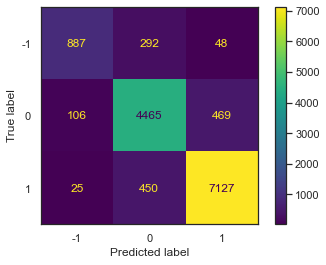

In [51]:
# Classification report
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_pred_train = mygrid_trainset.predict(X_train)



y_train = y_train
sns.set_theme(style='white')
def class_report(model,y_train,y_pred_train):
    print(classification_report(y_train,y_pred_train))
    cm = confusion_matrix(y_train,y_pred_train,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()


class_report(mygrid_trainset,y_train,y_pred_train)

**ROC on training data**

In [59]:
from sklearn.multiclass import  OneVsRestClassifier
from sklearn.preprocessing import  label_binarize
from sklearn.metrics import roc_curve,roc_auc_score,auc
# Reference: https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier
from sklearn.preprocessing import label_binarize

In [60]:
tfidf_vectorizer = TfidfVectorizer()
X  = tfidf_vectorizer.fit_transform(df_clean.iloc[:,0]).toarray()
y = df_clean.iloc[:,-1]

In [61]:
y = label_binarize(y, classes=[-1,0,1])
n_classes = y.shape[1]

X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)


# Without PCA
# pipe = Pipeline([('clf',OneVsRestClassifier(LogisticRegression(C=100, multi_class='multinomial',solver="lbfgs")))])

# With PCA
pipe = Pipeline([('pca',PCA(.90)),
('clf',OneVsRestClassifier(LogisticRegression(multi_class='multinomial',solver='lbfgs',C=10)))])


pipe.fit(X_train, y_train)
X_train = X_train.astype(int)
y_prediction_proba = pipe.predict_proba(X_train) 

In [62]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

def roc_curve_plot(value,y_train):
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_train[:,i], value[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i],lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
             
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve of multiclass; dataset")
    plt.show()
    roc_auc_scoring_macro_ovr = roc_auc_score(y_train,value, multi_class="OvR",average='macro')
    print("AUC score using OvR, macro-averaged over all classes: {:.3f}"
    .format(roc_auc_scoring_macro_ovr))

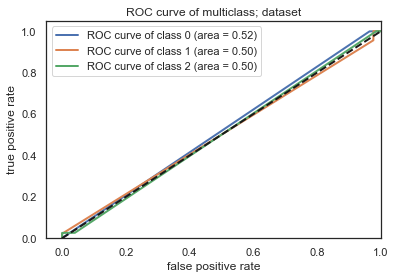

AUC score using OvR, macro-averaged over all classes: 0.506


In [63]:
roc_curve_plot(y_prediction_proba,y_train)
# with PCA: AUC score using OvR, macro-averaged over all classes: 0.506
# Without PCA: AUC score using OvR, macro-averaged over all classes: 0.502

Observations from Confusion matrix and ROC plots;
- With or without PCA both algorithms are randomly guessing.


**Building the model with best estimator and testing on test data**

In [64]:
tfidf_vectorizer = TfidfVectorizer()
X  = tfidf_vectorizer.fit_transform(df_clean.iloc[:,0]).toarray()
y = df_clean.iloc[:,-1]

In [65]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)

In [66]:
clf = LogisticRegression(C=100, multi_class='multinomial',solver='lbfgs')
clf.fit(X_train,y_train)

LogisticRegression(C=100, multi_class='multinomial')

**Test data**

              precision    recall  f1-score   support

          -1       0.72      0.56      0.63       307
           0       0.79      0.85      0.82      1260
           1       0.92      0.90      0.91      1901

    accuracy                           0.85      3468
   macro avg       0.81      0.77      0.79      3468
weighted avg       0.85      0.85      0.85      3468



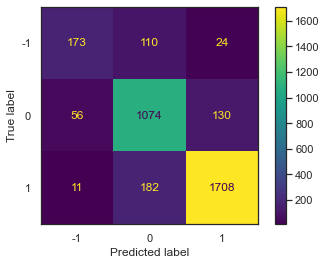

In [67]:
# Classification report test data
y_test = y_test
y_pred_test = clf.predict(X_test)
sns.set_theme(style='white')
def class_report(model,y_test,pred):
    print(classification_report(y_test,pred))
    cm = confusion_matrix(y_test,pred,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()


class_report(clf,y_test,y_pred_test)

**ROC on test data**

In [70]:
tfidf_vectorizer = TfidfVectorizer()
X  = tfidf_vectorizer.fit_transform(df_clean.iloc[:,0]).toarray()
y = df_clean.iloc[:,-1]

In [71]:
y = label_binarize(y, classes=[-1,0,1])
n_classes = y.shape[1]

X_train, X_test, y_train,y_test= train_test_split(
                                            X,y,test_size=.2,random_state=42, 
                                            stratify=y)


clf = OneVsRestClassifier(LogisticRegression(C=100, multi_class='multinomial',solver='lbfgs'))
clf.fit(X_train,y_train)

X_test = X_test.astype(int)
y_prediction_proba = clf.predict_proba(X_test) 

In [72]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

def roc_curve_plot_test(value,y_test):
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], value[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i],lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
             
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve of multiclass; dataset")
    plt.show()
    roc_auc_scoring_macro_ovr = roc_auc_score(y_test,value, multi_class="OvR",average='macro')
    print("AUC score using OvR, macro-averaged over all classes: {:.3f}"
    .format(roc_auc_scoring_macro_ovr))

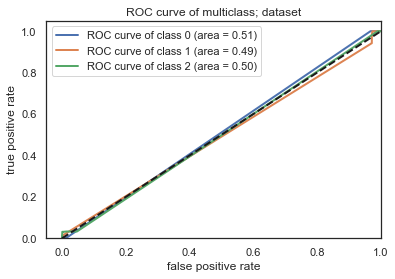

AUC score using OvR, macro-averaged over all classes: 0.500


In [73]:
roc_curve_plot_test(y_prediction_proba,y_test)
# Test data ROC: AUC score using OvR, macro-averaged over all classes: 0.500

## **Conclusion**

The following can be observed;
dataset|f1_score_macro_avg|AUC_score_avg
| ----------- | ----------- | ----------- |
df_clean_(train data)|0.96|0.502
df_clean (test data)|0.79|0.500

- From the ROC graphs and tables of Training and Testing data, we can see that the model is randomly guessing; a classifier should be above 0.5.

One major drawback of TF-IDF is as **the feature vectors are sparse and high-dimensional representations. The dimensionality increases with the size of the vocabulary, with most values being zero for any vector.** *(Practical Natural Language Processing A Comprehensive Guide to Building Real-World NLP Systems by Sowmya Vajjala, Bodhisattwa Majumder, Anuj Gupta, and Harshit Surana)*